# Supreme Court Final Project - Lucia de la Torre (Gonzalez Mantecon), Dec 2024

**This project aims to build a dataset of Supreme Court cases that incorporates:**

Case metadata: Docket numbers, case names, dates, and originating lower courts.

Transcripts: Full text of court proceedings for textual analysis.

Opinions: Links and summaries of decisions or opinions for each case.

The overall goal is to identify and visualize findings using heatmaps to highlight if technology-related discussions are present in Supreme Court cases in the US, in what way, and if possible, where.

**Step 1: Import Libraries and Load Data, Scrape Oral Argument Transcripts and Case Metadata**

Oral Argument Transcripts: minutes of oral arguments of Supreme Court cases, exchanges between justices and attorneys

In [1]:
import re
import requests
from bs4 import BeautifulSoup
import pandas as pd 

In [2]:
courtcases_url = "https://www.supremecourt.gov/oral_arguments/argument_transcript/2023"
raw_html = requests.get(courtcases_url).content
court_doc = BeautifulSoup(raw_html, "html.parser")

In [3]:
all_rows = court_doc.find_all('tr')
each_case = []
for row in all_rows[1:]:
    if row.td:
        this_row = {}
        each_cell=row.find_all('td')
        this_row['docket_num'] = each_cell[0].span.text
        this_row['transcript_link'] = each_cell[0].a['href'].split('/')[-1]
        this_row['case_name'] = each_cell[0].find_all('span')[1].text
        this_row['date'] = each_cell[1].text
        each_case.append(this_row)

In [4]:
transcripts_df = pd.DataFrame(each_case)

In [5]:
transcripts_df.to_csv('oral_argument_transcripts.csv', index=False)

In [6]:
transcripts_df.head()

,docket_num,transcript_link,case_name,date
0,23-108,23-108_o7jp.pdf,Snyder v. United States,04/15/24
1,23-50,23-50_g3bh.pdf,Chiaverini v. City of Napoleon,04/15/24
2,23-5572,23-5572_l537.pdf,Fischer v. United States,04/16/24
3,22-982,22-982_m64n.pdf,Thornell v. Jones,04/17/24
4,23-175,23-175_20f4.pdf,City of Grants Pass v. Johnson,04/22/24


In [7]:
print(transcripts_df[['docket_num', 'transcript_link']].head())


  docket_num   transcript_link
0     23-108   23-108_o7jp.pdf
1      23-50    23-50_g3bh.pdf
2    23-5572  23-5572_l537.pdf
3     22-982   22-982_m64n.pdf
4     23-175   23-175_20f4.pdf


In [8]:
transcripts_df['transcript_link'] = transcripts_df['transcript_link'].apply(
    lambda x: f'<a href="https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/{x}" target="_blank">{x}</a>'
)
from IPython.display import display, HTML
display(HTML(transcripts_df.to_html(escape=False)))

,docket_num,transcript_link,case_name,date
0,23-108,23-108_o7jp.pdf,Snyder v. United States,04/15/24
1,23-50,23-50_g3bh.pdf,Chiaverini v. City of Napoleon,04/15/24
2,23-5572,23-5572_l537.pdf,Fischer v. United States,04/16/24
3,22-982,22-982_m64n.pdf,Thornell v. Jones,04/17/24
4,23-175,23-175_20f4.pdf,City of Grants Pass v. Johnson,04/22/24
5,22-1218,22-1218_h3ci.pdf,Smith v. Spizzirri,04/22/24
6,23-334,23-334_ifjm.pdf,Dept. of State v. Munoz,04/23/24
7,23-367,23-367_5he6.pdf,Starbucks Corp. v. McKinney,04/23/24
8,23-726,23-726_ggco.pdf,Moyle v. United States,04/24/24
9,23-939,23-939_3fb4.pdf,Trump v. United States,04/25/24


The metadata and opinions are present in a different page, the Slip Opinions Page, a document with the official written opinions of the Court, final decisions on cases and justices’ reasonings. 

In [9]:
metadata_url = 'https://www.supremecourt.gov/opinions/slipopinion/23'
raw_html = requests.get(metadata_url).content
metadata_doc = BeautifulSoup(raw_html, "html.parser")

In [10]:
all_rows = metadata_doc.find_all('tr')

In [11]:
each_metadata = []
for row in all_rows[1:]:  
    if row.td:
        this_row = {}
        each_cell = row.find_all('td')

        this_row['docket_num'] = each_cell[2].text.strip()
        
        metadata_link = each_cell[3].find('a', href=True) if len(each_cell) > 3 else None
        
        if metadata_link:
            this_row['opinion_link'] = metadata_link['href'].split('/')[-1]
        else:
            this_row['opinion_link'] = None 

        this_row['case_name'] = each_cell[3].text.strip() if len(each_cell) > 2 else None

        this_row['date'] = each_cell[1].text.strip() if len(each_cell) > 3 else None

        each_metadata.append(this_row)

In [12]:
metadata_df = pd.DataFrame(each_metadata)

In [13]:
metadata_df.head()

,docket_num,opinion_link,case_name,date
0,24A78,603us1r60_32q3.pdf,Department of Education v. Louisiana,8/16/24
1,22-1008,603us1r59_4fci.pdf,"Corner Post, Inc. v. Board of Governors",7/01/24
2,22-277,603us1r58_8mj9.pdf,"Moody v. NetChoice, LLC",7/01/24
3,23-939,603us1r57_6k47.pdf,Trump v. United States,7/01/24
4,23-175,23-175_19m2.pdf,City of Grants Pass v. Johnson,6/28/24


In [14]:
metadata_df['opinion_link'] = 'https://www.supremecourt.gov/opinions/slipopinion/23' + metadata_df['opinion_link']

In [15]:
metadata_df['opinion_link'] = metadata_df['opinion_link'].apply(
    lambda x: f'<a href="{x}" target="_blank">{x.split("/")[-1]}</a>' if isinstance(x, str) else None
)

In [16]:
display(HTML(metadata_df.to_html(escape=False)))

,docket_num,opinion_link,case_name,date
0,24A78,23603us1r60_32q3.pdf,Department of Education v. Louisiana,8/16/24
1,22-1008,23603us1r59_4fci.pdf,"Corner Post, Inc. v. Board of Governors",7/01/24
2,22-277,23603us1r58_8mj9.pdf,"Moody v. NetChoice, LLC",7/01/24
3,23-939,23603us1r57_6k47.pdf,Trump v. United States,7/01/24
4,23-175,2323-175_19m2.pdf,City of Grants Pass v. Johnson,6/28/24
5,23-5572,23603us1r55_6j36.pdf,Fischer v. United States,6/28/24
6,22-451,2322-451_7m58.pdf,Loper Bright Enterprises v. Raimondo,6/28/24
7,23-726,2323-726_6jgm.pdf,Moyle v. United States,6/27/24
8,23A349,23603us1r52_d18f.pdf,Ohio v. Environmental Protection Agency,6/27/24
9,23-124,2323-124new_nkp1.pdf,Harrington v. Purdue Pharma L.P.\nRevisions: 6/27/24,6/27/24


**Step 3: Merge both datasets**

The merge is done using docket_num. This creates a dataframe that contains all cases with their docket number, case name, date, and a link to the opinions and transcript pages.

In [17]:
courtcases_df = pd.merge(
    transcripts_df[['docket_num', 'case_name', 'date', 'transcript_link']], 
    metadata_df[['docket_num', 'case_name', 'date', 'opinion_link']], 
    on='docket_num', how='inner'
)

courtcases_df = courtcases_df[['docket_num', 'case_name_x', 'date_x', 'transcript_link', 'opinion_link']]

courtcases_df.rename(columns={
    'case_name_x': 'case_name',
    'date_x': 'date'
}, inplace=True)

print(courtcases_df.head())

  docket_num                       case_name      date  \
0     23-108         Snyder v. United States  04/15/24   
1      23-50  Chiaverini v. City of Napoleon  04/15/24   
2    23-5572        Fischer v. United States  04/16/24   
3     22-982               Thornell v. Jones  04/17/24   
4     23-175  City of Grants Pass v. Johnson  04/22/24   

                                     transcript_link  \
0  <a href="https://www.supremecourt.gov/oral_arg...   
1  <a href="https://www.supremecourt.gov/oral_arg...   
2  <a href="https://www.supremecourt.gov/oral_arg...   
3  <a href="https://www.supremecourt.gov/oral_arg...   
4  <a href="https://www.supremecourt.gov/oral_arg...   

                                        opinion_link  
0  <a href="https://www.supremecourt.gov/opinions...  
1  <a href="https://www.supremecourt.gov/opinions...  
2  <a href="https://www.supremecourt.gov/opinions...  
3  <a href="https://www.supremecourt.gov/opinions...  
4  <a href="https://www.supremecourt.go

In [18]:
import re

def extract_url(anchor_tag):
    match = re.search(r'href="(http[^\"]+)"', anchor_tag)
    return match.group(1) if match else None

courtcases_df['opinion_link'] = courtcases_df['opinion_link'].apply(extract_url)
courtcases_df['transcript_link'] = courtcases_df['transcript_link'].apply(extract_url)

In [19]:
courtcases_df = courtcases_df[['docket_num', 'case_name', 'date', 'transcript_link', 'opinion_link']]

courtcases_df['transcript_link'] = courtcases_df['transcript_link'].apply(
    lambda x: f'<a href="{x}" target="_blank">{x}</a>' if isinstance(x, str) else None
)

courtcases_df['opinion_link'] = courtcases_df['opinion_link'].apply(
    lambda x: f'<a href="{x}" target="_blank">{x}</a>' if isinstance(x, str) else None
)

courtcases_df = courtcases_df[['docket_num', 'case_name', 'date', 'transcript_link', 'opinion_link']]

display(HTML(courtcases_df.to_html(escape=False)))

,docket_num,case_name,date,transcript_link,opinion_link
0,23-108,Snyder v. United States,04/15/24,https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/23-108_o7jp.pdf,https://www.supremecourt.gov/opinions/slipopinion/23603us1r48_g3ci.pdf
1,23-50,Chiaverini v. City of Napoleon,04/15/24,https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/23-50_g3bh.pdf,https://www.supremecourt.gov/opinions/slipopinion/23602us1r40_f20g.pdf
2,23-5572,Fischer v. United States,04/16/24,https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/23-5572_l537.pdf,https://www.supremecourt.gov/opinions/slipopinion/23603us1r55_6j36.pdf
3,22-982,Thornell v. Jones,04/17/24,https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/22-982_m64n.pdf,https://www.supremecourt.gov/opinions/slipopinion/23602us1r27_jhek.pdf
4,23-175,City of Grants Pass v. Johnson,04/22/24,https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/23-175_20f4.pdf,https://www.supremecourt.gov/opinions/slipopinion/2323-175_19m2.pdf
5,22-1218,Smith v. Spizzirri,04/22/24,https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/22-1218_h3ci.pdf,https://www.supremecourt.gov/opinions/slipopinion/23601us2r22_o7jq.pdf
6,23-334,Dept. of State v. Munoz,04/23/24,https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/23-334_ifjm.pdf,https://www.supremecourt.gov/opinions/slipopinion/23602us1r46_gfbi.pdf
7,23-367,Starbucks Corp. v. McKinney,04/23/24,https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/23-367_5he6.pdf,https://www.supremecourt.gov/opinions/slipopinion/23602us1r34_e29g.pdf
8,23-726,Moyle v. United States,04/24/24,https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/23-726_ggco.pdf,https://www.supremecourt.gov/opinions/slipopinion/2323-726_6jgm.pdf
9,23-939,Trump v. United States,04/25/24,https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/23-939_3fb4.pdf,https://www.supremecourt.gov/opinions/slipopinion/23603us1r57_6k47.pdf


In [20]:
courtcases_df

,docket_num,case_name,date,transcript_link,opinion_link
0,23-108,Snyder v. United States,04/15/24,"<a href=""https://www.supremecourt.gov/oral_arg...","<a href=""https://www.supremecourt.gov/opinions..."
1,23-50,Chiaverini v. City of Napoleon,04/15/24,"<a href=""https://www.supremecourt.gov/oral_arg...","<a href=""https://www.supremecourt.gov/opinions..."
2,23-5572,Fischer v. United States,04/16/24,"<a href=""https://www.supremecourt.gov/oral_arg...","<a href=""https://www.supremecourt.gov/opinions..."
3,22-982,Thornell v. Jones,04/17/24,"<a href=""https://www.supremecourt.gov/oral_arg...","<a href=""https://www.supremecourt.gov/opinions..."
4,23-175,City of Grants Pass v. Johnson,04/22/24,"<a href=""https://www.supremecourt.gov/oral_arg...","<a href=""https://www.supremecourt.gov/opinions..."
5,22-1218,Smith v. Spizzirri,04/22/24,"<a href=""https://www.supremecourt.gov/oral_arg...","<a href=""https://www.supremecourt.gov/opinions..."
6,23-334,Dept. of State v. Munoz,04/23/24,"<a href=""https://www.supremecourt.gov/oral_arg...","<a href=""https://www.supremecourt.gov/opinions..."
7,23-367,Starbucks Corp. v. McKinney,04/23/24,"<a href=""https://www.supremecourt.gov/oral_arg...","<a href=""https://www.supremecourt.gov/opinions..."
8,23-726,Moyle v. United States,04/24/24,"<a href=""https://www.supremecourt.gov/oral_arg...","<a href=""https://www.supremecourt.gov/opinions..."
9,23-939,Trump v. United States,04/25/24,"<a href=""https://www.supremecourt.gov/oral_arg...","<a href=""https://www.supremecourt.gov/opinions..."


In [23]:
court_cases_dict = courtcases_df.to_dict(orient='records')

In [24]:
print(court_cases_dict)

[{'docket_num': '23-108', 'case_name': 'Snyder v. United States', 'date': '04/15/24', 'transcript_link': '<a href="https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/23-108_o7jp.pdf" target="_blank">https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/23-108_o7jp.pdf</a>', 'opinion_link': '<a href="https://www.supremecourt.gov/opinions/slipopinion/23603us1r48_g3ci.pdf" target="_blank">https://www.supremecourt.gov/opinions/slipopinion/23603us1r48_g3ci.pdf</a>'}, {'docket_num': '23-50', 'case_name': 'Chiaverini v. City of Napoleon', 'date': '04/15/24', 'transcript_link': '<a href="https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/23-50_g3bh.pdf" target="_blank">https://www.supremecourt.gov/oral_arguments/argument_transcripts/2023/23-50_g3bh.pdf</a>', 'opinion_link': '<a href="https://www.supremecourt.gov/opinions/slipopinion/23602us1r40_f20g.pdf" target="_blank">https://www.supremecourt.gov/opinions/slipopinion/23602us1r40_f20g.pdf<

**Step 4: Analyze the data**

In [ ]:

import time
import requests
import os

output_dir = 'court_docs'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for case in court_cases_dict:
    time.sleep(2)

    transcript_url = case['transcript_link']
    opinion_url = case['opinion_link']
    
    transcript_url_clean = transcript_url.split('"')[1] if '"' in transcript_url else transcript_url
    opinion_url_clean = opinion_url.split('"')[1] if '"' in opinion_url else opinion_url
    
    transcript_file_name = transcript_url_clean.split('/')[-1]
    opinion_file_name = opinion_url_clean.split('/')[-1]
    
    transcript_file_path = os.path.join(output_dir, transcript_file_name)
    opinion_file_path = os.path.join(output_dir, opinion_file_name)
    
    def download_file(url, file_path):
        try:
            r = requests.get(url, stream=True)
            r.raise_for_status()  # Check if the request was successful
            
            with open(file_path, 'wb') as file:
                for chunk in r.iter_content(chunk_size=1024):
                    if chunk:
                        file.write(chunk)
            print(f"Downloaded: {file_path}")
        
        except requests.exceptions.RequestException as e:
            print(f"Failed to download {file_path}: {e}")

    download_file(transcript_url_clean, transcript_file_path)
    download_file(opinion_url_clean, opinion_file_path)

Identifying how many times the words 'artificial intelligence' or 'AI' were mentioned

In [26]:
import os
import time

txt_directory = 'court_docs2'

for case in court_cases_dict:
    time.sleep(2)
    
    transcript_filename = case['transcript_link'].replace('<a href="', '').split('"')[0].split('/')[-1].replace('.pdf', '.txt')
    opinion_filename = case['opinion_link'].replace('<a href="', '').split('"')[0].split('/')[-1].replace('.pdf', '.txt')
    
    transcript_file_path = os.path.join(txt_directory, transcript_filename)
    opinion_file_path = os.path.join(txt_directory, opinion_filename)
    
    try:
        if os.path.exists(transcript_file_path):
            with open(transcript_file_path, 'r', encoding='utf-8') as file:
                transcript_text = file.read()
                
            if 'artificial intelligence' in transcript_text.lower() or 'ai' in transcript_text.lower():
                print(f"Found 'artificial intelligence' or 'AI' in transcript for {case['case_name']}")
        else:
            print(f"Transcript file not found for {case['case_name']}")
        
    except Exception as e:
        print(f"Failed to process transcript for {case['case_name']}. Error: {e}")
    
    try:
        if os.path.exists(opinion_file_path):
            with open(opinion_file_path, 'r', encoding='utf-8') as file:
                opinion_text = file.read()
                
            if 'artificial intelligence' in opinion_text.lower() or 'ai' in opinion_text.lower():
                print(f"Found 'artificial intelligence' or 'AI' in opinion for {case['case_name']}")
        else:
            print(f"Opinion file not found for {case['case_name']}")
        
    except Exception as e:
        print(f"Failed to process opinion for {case['case_name']}. Error: {e}")


Found 'artificial intelligence' or 'AI' in transcript for Snyder v. United States
Found 'artificial intelligence' or 'AI' in opinion for Snyder v. United States
Found 'artificial intelligence' or 'AI' in transcript for Chiaverini v. City of Napoleon
Found 'artificial intelligence' or 'AI' in opinion for Chiaverini v. City of Napoleon
Found 'artificial intelligence' or 'AI' in transcript for Fischer v. United States
Found 'artificial intelligence' or 'AI' in opinion for Fischer v. United States
Found 'artificial intelligence' or 'AI' in transcript for Thornell v. Jones
Found 'artificial intelligence' or 'AI' in opinion for Thornell v. Jones
Found 'artificial intelligence' or 'AI' in transcript for City of Grants Pass v. Johnson
Found 'artificial intelligence' or 'AI' in opinion for City of Grants Pass v. Johnson
Found 'artificial intelligence' or 'AI' in transcript for Smith v. Spizzirri
Found 'artificial intelligence' or 'AI' in opinion for Smith v. Spizzirri
Found 'artificial intellig

I realized this found all the times where the letter combination 'ai' was used, hence why it was found in all files. I tweaked my search below to find where 'misinformation was used'.

In [30]:
import os
import time

txt_directory = 'court_docs2'

for case in court_cases_dict:
    time.sleep(2)
    
    transcript_filename = case['transcript_link'].replace('<a href="', '').split('"')[0].split('/')[-1].replace('.pdf', '.txt')
    opinion_filename = case['opinion_link'].replace('<a href="', '').split('"')[0].split('/')[-1].replace('.pdf', '.txt')
    
    transcript_file_path = os.path.join(txt_directory, transcript_filename)
    opinion_file_path = os.path.join(txt_directory, opinion_filename)
    
    try:
        if os.path.exists(transcript_file_path):
            with open(transcript_file_path, 'r', encoding='utf-8') as file:
                transcript_text = file.read()
                
            if 'misinformation' in transcript_text.lower():
                print(f"Found 'misinformation'in transcript for {case['case_name']}")
        else:
            print(f"Transcript file not found for {case['case_name']}")
        
    except Exception as e:
        print(f"Failed to process transcript for {case['case_name']}. Error: {e}")
    
    try:
        if os.path.exists(opinion_file_path):
            with open(opinion_file_path, 'r', encoding='utf-8') as file:
                opinion_text = file.read()
                
            if 'misinformation' in opinion_text.lower():
                print(f"Found 'misinformation' in opinion for {case['case_name']}")
        else:
            print(f"Opinion file not found for {case['case_name']}")
        
    except Exception as e:
        print(f"Failed to process opinion for {case['case_name']}. Error: {e}")

Found 'misinformation'in transcript for Murthy, Surgeon Gen. v. Missouri
Found 'misinformation'in transcript for Moody v. NetChoice, LLC


No relevant results.

In [32]:
import os
import time

txt_directory = 'court_docs2'

for case in court_cases_dict:
    time.sleep(2)
    
    transcript_filename = case['transcript_link'].replace('<a href="', '').split('"')[0].split('/')[-1].replace('.pdf', '.txt')
    opinion_filename = case['opinion_link'].replace('<a href="', '').split('"')[0].split('/')[-1].replace('.pdf', '.txt')
    
    transcript_file_path = os.path.join(txt_directory, transcript_filename)
    opinion_file_path = os.path.join(txt_directory, opinion_filename)
    
    try:
        if os.path.exists(transcript_file_path):
            with open(transcript_file_path, 'r', encoding='utf-8') as file:
                transcript_text = file.read()
                
            if 'fake news' in transcript_text.lower():
                print(f"Found 'fake news' in transcript for {case['case_name']}")
    
    except Exception as e:
        print(f"Failed to process transcript for {case['case_name']}. Error: {e}")
    
    try:
        if os.path.exists(opinion_file_path):
            with open(opinion_file_path, 'r', encoding='utf-8') as file:
                opinion_text = file.read()
                
            if 'fake news' in opinion_text.lower():
                print(f"Found 'fake news' in opinion for {case['case_name']}")
    
    except Exception as e:
        print(f"Failed to process opinion for {case['case_name']}. Error: {e}")

Again, no relevant results.

In [33]:
import os
import time

txt_directory = 'court_docs2'

for case in court_cases_dict:
    time.sleep(2)
    
    transcript_filename = case['transcript_link'].replace('<a href="', '').split('"')[0].split('/')[-1].replace('.pdf', '.txt')
    opinion_filename = case['opinion_link'].replace('<a href="', '').split('"')[0].split('/')[-1].replace('.pdf', '.txt')
    
    transcript_file_path = os.path.join(txt_directory, transcript_filename)
    opinion_file_path = os.path.join(txt_directory, opinion_filename)
    
    try:
        if os.path.exists(transcript_file_path):
            with open(transcript_file_path, 'r', encoding='utf-8') as file:
                transcript_text = file.read()
                
            if 'cybersecurity' in transcript_text.lower():
                print(f"Found 'cybersecurity' in transcript for {case['case_name']}")
    
    except Exception as e:
        print(f"Failed to process transcript for {case['case_name']}. Error: {e}")
    
    try:
        if os.path.exists(opinion_file_path):
            with open(opinion_file_path, 'r', encoding='utf-8') as file:
                opinion_text = file.read()
                
            if 'cybersecurity' in opinion_text.lower():
                print(f"Found 'cybersecurity' in opinion for {case['case_name']}")
    
    except Exception as e:
        print(f"Failed to process opinion for {case['case_name']}. Error: {e}")

I decided to widen the scope and find all mentions of the word 'technology'

In [38]:
import os
import time

txt_directory = 'court_docs2'

for case in court_cases_dict:
    time.sleep(2)
    
    transcript_filename = case['transcript_link'].replace('<a href="', '').split('"')[0].split('/')[-1].replace('.pdf', '.txt')
    opinion_filename = case['opinion_link'].replace('<a href="', '').split('"')[0].split('/')[-1].replace('.pdf', '.txt')
    
    transcript_file_path = os.path.join(txt_directory, transcript_filename)
    opinion_file_path = os.path.join(txt_directory, opinion_filename)
    
    try:
        if os.path.exists(transcript_file_path):
            with open(transcript_file_path, 'r', encoding='utf-8') as file:
                transcript_text = file.read()
                
            if 'technology' in transcript_text.lower():
                print(f"Found 'technology' in transcript for {case['case_name']}")
    
    except Exception as e:
        print(f"Failed to process transcript for {case['case_name']}. Error: {e}")
    
    try:
        if os.path.exists(opinion_file_path):
            with open(opinion_file_path, 'r', encoding='utf-8') as file:
                opinion_text = file.read()
                
            if 'technology' in opinion_text.lower():
                print(f"Found 'technology' in opinion for {case['case_name']}")
    
    except Exception as e:
        print(f"Failed to process opinion for {case['case_name']}. Error: {e}")

Found 'technology' in transcript for Ohio v. EPA
Found 'technology' in transcript for Garland, Att'y Gen. v. Cargill
Found 'technology' in transcript for Campos-Chaves v. Garland, Att'y Gen.
Found 'technology' in transcript for Loper Bright Enterprises, Inc. v. Raimondo, Sec. of Comm.
Found 'technology' in transcript for United States v. Rahimi
Found 'technology' in transcript for Acheson Hotels, LLC v. Laufer
Found 'technology' in transcript for Alexander v. SC Conference of NAACP


Due to time constraints, even though these results weren't very conclusive, I decided to map them.

In [39]:
import os
import time

txt_directory = 'court_docs2'

results = []

for case in court_cases_dict:
    time.sleep(2)
    
    transcript_filename = case['transcript_link'].replace('<a href="', '').split('"')[0].split('/')[-1].replace('.pdf', '.txt')
    opinion_filename = case['opinion_link'].replace('<a href="', '').split('"')[0].split('/')[-1].replace('.pdf', '.txt')
    
    transcript_file_path = os.path.join(txt_directory, transcript_filename)
    opinion_file_path = os.path.join(txt_directory, opinion_filename)
    
    transcript_found = False
    opinion_found = False
    
    try:
        if os.path.exists(transcript_file_path):
            with open(transcript_file_path, 'r', encoding='utf-8') as file:
                transcript_text = file.read()
                
            if 'technology' in transcript_text.lower():
                transcript_found = True
    
    except Exception as e:
        print(f"Failed to process transcript for {case['case_name']}. Error: {e}")
    
    try:
        if os.path.exists(opinion_file_path):
            with open(opinion_file_path, 'r', encoding='utf-8') as file:
                opinion_text = file.read()
                
            if 'technology' in opinion_text.lower():
                opinion_found = True
    
    except Exception as e:
        print(f"Failed to process opinion for {case['case_name']}. Error: {e}")
    
    results.append({
        'case_name': case['case_name'],
        'transcript_found': transcript_found,
        'opinion_found': opinion_found
    })

**Step 5: Visualize the data**

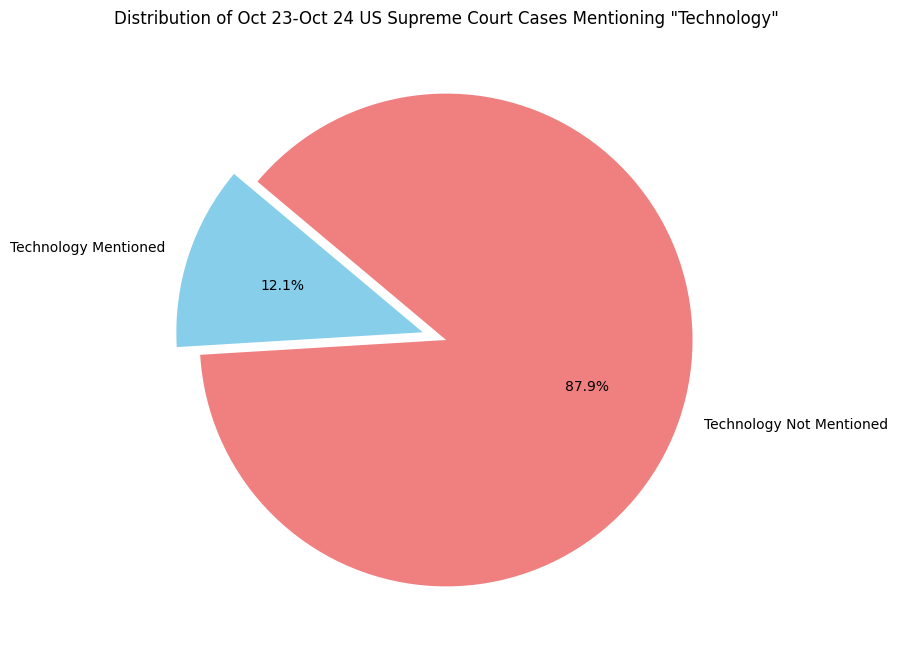

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.DataFrame(results)

total_cases = len(df)
technology_cases = df['transcript_found'].sum() + df['opinion_found'].sum()

non_technology_cases = total_cases - technology_cases

labels = ['Technology Mentioned', 'Technology Not Mentioned']
sizes = [technology_cases, non_technology_cases]
colors = ['skyblue', 'lightcoral']

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', colors=colors, startangle=140, explode=(0.1, 0))  # explode for highlighting
plt.title('Distribution of Oct 23-Oct 24 US Supreme Court Cases Mentioning "Technology"')
plt.show()


**STRENGTHS**

Robust structure/framework to analyze word frequency in Supreme Court Cases
Skills used: scraping, parsing, pandas, regex.

**WEAKNESSES**

Relevant data missing (e.g. geographical data)
Execution: the findings don’t lead to any significant conclusions.

**NEXT STEPS**

Add more data to the court_cases dataframe/dictionary
Geographical data of lower courts
Case summaries?

More complex word frequency search
Find the whole sentence or context
Find what section of the transcript/opinions doc it’s mentioned in
Using AI (e.g. spaCy) to understand in what context the word is used
Identify relevant keywords to search